References:
- https://www.open3d.org/docs/release/tutorial/pipelines/icp_registration.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ortho_group.html
- https://www.open3d.org/docs/latest/python_api/open3d.pipelines.registration.registration_ransac_based_on_feature_matching.html
- https://www.open3d.org/docs/0.7.0/python_api/open3d.geometry.estimate_normals.html

In [1]:
!pip install open3d -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 70.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.stats import ortho_group

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## point-to-point ICP registration

In [3]:
def preprocess_point_cloud(pcd, voxel_size=0.1):
    """
    Preprocess a point cloud by downsampling and computing Fast Point Feature Histograms features.
    """
    pcd_down = pcd.voxel_down_sample(voxel_size)
    #estimate normals for better feature computation
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down, o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100))
    return pcd_down, fpfh

def get_ransac_transformation(pcd1, pcd2, voxel_size=0.1):
    """
    Compute an initial transformation matrix using RANSAC feature matching.
    """
    #preprocess point clouds and get FPFH features
    pcd1_down, fpfh1 = preprocess_point_cloud(pcd1, voxel_size)
    pcd2_down, fpfh2 = preprocess_point_cloud(pcd2, voxel_size)
    distance_threshold = voxel_size * 1.5 #distance threshold for RANSAC correspondence matching

    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        pcd1_down, pcd2_down, fpfh1, fpfh2, True, distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(), 5,
        [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
         o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
        o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result.transformation

def get_random_transformation():
    """
    Returns a 4x4 orthonormal matrix with valid rotation and translation components.
    """
    rotation = ortho_group.rvs(dim=3)
    translation = np.random.uniform(-0.2, 0.2, size=(3, 1))
    T_init = np.eye(4)
    T_init[:3, :3] = rotation
    T_init[:3, 3] = translation.flatten()
    return T_init

def run_icp(pcd1, pcd2, T_init, thresh=0.02, max_iter=10000):
    """
    Runs point-to-point ICP algorithm on two point clouds and prints results.
    """
    evaluation = o3d.pipelines.registration.evaluate_registration(pcd1, pcd2, thresh, T_init)
    print(f"Initial scores - Fitness: {evaluation.fitness:.5f}, Inlier RMSE: {evaluation.inlier_rmse:.5f}, Correspondence Set Size: {len(evaluation.correspondence_set)}")

    icp_result = o3d.pipelines.registration.registration_icp(
        pcd1, pcd2, thresh, T_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iter))

    print('ICP Estimated (Learnt) Transformation Matrix:')
    print(icp_result.transformation)
    print(f"Estimated scores - Fitness: {icp_result.fitness:.5f}, Inlier RMSE: {icp_result.inlier_rmse:.5f}, Correspondence Set Size: {len(icp_result.correspondence_set)}")
    print(f"Improvements- Fitness: {(icp_result.fitness - evaluation.fitness):.5f}, Inlier RMSE: {(evaluation.inlier_rmse - icp_result.inlier_rmse):.5f}")
    return icp_result

In [4]:
base = '/kaggle/input/cv-pcd/'
pcds = [os.path.join(base, pcd) for pcd in os.listdir(base)]

pcd1 = o3d.io.read_point_cloud(pcds[0])
pcd2 = o3d.io.read_point_cloud(pcds[1])

thresh_arr = [0.02, 0.05, 0.075, 0.1]

In [5]:
T_random = get_random_transformation()
print("Initial Random Transformation Matrix:")
print(T_random)
print()

for t in thresh_arr:
    print('Threshold:', t)
    temp = run_icp(pcd1, pcd2, T_random, thresh=t)
    print()

Initial Random Transformation Matrix:
[[ 0.97169058 -0.20783057  0.112356   -0.19817445]
 [ 0.10247987  0.79926955  0.59217064  0.05540264]
 [ 0.2128739   0.56389241 -0.79794114  0.08773317]
 [ 0.          0.          0.          1.        ]]

Threshold: 0.02
Initial scores - Fitness: 0.00552, Inlier RMSE: 0.01445, Correspondence Set Size: 127
ICP Estimated (Learnt) Transformation Matrix:
[[ 0.97187394 -0.20625819  0.11366    -0.19963715]
 [ 0.09964518  0.79745296  0.59509631  0.05579959]
 [ 0.21338199  0.56703293 -0.79557639  0.08842654]
 [ 0.          0.          0.          1.        ]]
Estimated scores - Fitness: 0.00565, Inlier RMSE: 0.01417, Correspondence Set Size: 130
Improvements- Fitness: 0.00013, Inlier RMSE: 0.00027

Threshold: 0.05
Initial scores - Fitness: 0.03849, Inlier RMSE: 0.03527, Correspondence Set Size: 885
ICP Estimated (Learnt) Transformation Matrix:
[[ 0.97596309 -0.20048253  0.08545647 -0.11487873]
 [ 0.11639827  0.81101731  0.57332571  0.03394549]
 [ 0.184248

In [6]:
T_ransac = get_random_transformation()
print("Initial RANSAC Transformation Matrix:")
print(T_ransac)
print()

for t in thresh_arr:
    print('Threshold:', t)
    temp = run_icp(pcd1, pcd2, T_ransac, thresh=t)
    print()

Initial RANSAC Transformation Matrix:
[[ 0.83927707 -0.32463641  0.43614814  0.05552524]
 [-0.30954466 -0.9447808  -0.10757015 -0.17242915]
 [-0.44698558  0.04472617  0.89342233 -0.02701105]
 [ 0.          0.          0.          1.        ]]

Threshold: 0.02
Initial scores - Fitness: 0.00709, Inlier RMSE: 0.01342, Correspondence Set Size: 163
ICP Estimated (Learnt) Transformation Matrix:
[[ 0.84598424 -0.3255806   0.42226525  0.05708758]
 [-0.31393738 -0.94425779 -0.09909872 -0.17425743]
 [-0.43099187  0.04872889  0.90103912 -0.0157582 ]
 [ 0.          0.          0.          1.        ]]
Estimated scores - Fitness: 0.00818, Inlier RMSE: 0.01272, Correspondence Set Size: 188
Improvements- Fitness: 0.00109, Inlier RMSE: 0.00069

Threshold: 0.05
Initial scores - Fitness: 0.02875, Inlier RMSE: 0.03269, Correspondence Set Size: 661
ICP Estimated (Learnt) Transformation Matrix:
[[ 0.85823939 -0.34562288  0.37943375  0.06452456]
 [-0.35063868 -0.93469458 -0.05829715 -0.02099694]
 [-0.374803

## Visualization with best hyperparameters

Initial scores - Fitness: 0.00709, Inlier RMSE: 0.01342, Correspondence Set Size: 163
ICP Estimated (Learnt) Transformation Matrix:
[[ 0.84598424 -0.3255806   0.42226525  0.05708758]
 [-0.31393738 -0.94425779 -0.09909872 -0.17425743]
 [-0.43099187  0.04872889  0.90103912 -0.0157582 ]
 [ 0.          0.          0.          1.        ]]
Estimated scores - Fitness: 0.00818, Inlier RMSE: 0.01272, Correspondence Set Size: 188
Improvements- Fitness: 0.00109, Inlier RMSE: 0.00069


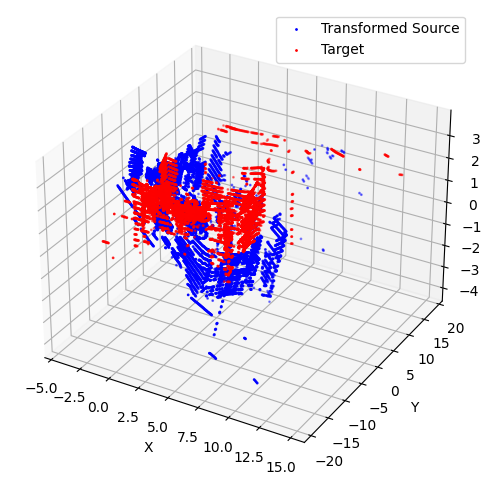

In [7]:
temp = run_icp(pcd1, pcd2, T_ransac, thresh=0.02)
transformed_pcd1 = pcd1.transform(temp.transformation)

points1 = np.asarray(transformed_pcd1.points)
points2 = np.asarray(pcd2.points)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points1[:, 0], points1[:, 1], points1[:, 2], s=1, c='b', label="Transformed Source")
ax.scatter(points2[:, 0], points2[:, 1], points2[:, 2], s=1, c='r', label="Target")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()